# Import and install libraries

In [ ]:
!pip install cdsapi xarray netCDF4 geopandas statsmodels pygrib


In [ ]:
import requests, time, zipfile, glob, os
import pandas as pd
from datetime import datetime
import geopandas as gpd
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import numpy as np
import cdsapi
import calendar
import xarray as xr
import statsmodels.formula.api as smf
import xarray as xr_utils

In [ ]:
# credenziali cdsapi
%%bash
cat <<EOF > ~/.cdsapirc
url: https://cds.climate.copernicus.eu/api
key: d5b5087e-275b-4bb3-95e8-e48e04520655
EOF
chmod 600 ~/.cdsapirc


# EEA data

In [ ]:
API_BASE    = "https://eeadmz1-downloads-api-appservice.azurewebsites.net/"
START       = "2018-01-01T00:00:00Z"
END         = "2025-06-01T00:00:00Z"
COUNTRIES   = ["IT"]
CITIES      = ["Milano (greater city)"]
POLLUTANTS  = ["NO2"]
DATASET     = 2      # E1a verificati 2013-22
AGG_TYPE    = "hour"
SAVE_ZIP    = "/content/no2_20182023.zip"
EXTRACT_DIR = "/content/no2_20182023"


In [ ]:
# ── 3. Creazione job asincrono (ParquetFile/async)
body = {
    "countries":       COUNTRIES,
    "cities":          CITIES,
    "pollutants":      POLLUTANTS,
    "dataset":         DATASET,
    "dateTimeStart":   START,
    "dateTimeEnd":     END,
    "aggregationType": AGG_TYPE,
}
resp = requests.post(f"{API_BASE}ParquetFile/async", json=body, timeout=60)
resp.raise_for_status()
job_url = resp.text.strip().strip('"')
print("Job URL:", job_url)

Job URL: https://eeadmz1batchservice02.blob.core.windows.net/downloads/c9872a1d-1944-42a7-88e0-4d0ab0064d59/ParquetFiles-pgdev.zip


In [ ]:
# ── 4. Polling e download ZIP
t0 = datetime.now()
while True:
    r = requests.get(job_url, timeout=60)
    if r.status_code == 200:
        with open(SAVE_ZIP, "wb") as f:
            f.write(r.content)
        print("Scaricato:", SAVE_ZIP)
        break
    elif r.status_code == 404:
        if (datetime.now() - t0).seconds > 3600:
            raise TimeoutError("Job non completato entro 1h")
        time.sleep(20)
    else:
        r.raise_for_status()


Scaricato: /content/no2_20182023.zip


In [ ]:
# ── 5. Estrai lo ZIP
!unzip -q /content/no2_20182023.zip -d /content/no2_20182023
!ls -1 /content/no2_20182023 | head -10

E1a


In [ ]:
# ── 6. Concatena tutti i Parquet in df2m
files = sorted(glob.glob(f"{EXTRACT_DIR}/E1a/*.parquet"))
df2m_1823 = pd.concat((pd.read_parquet(f) for f in files), ignore_index=True)
df2m_1823["datetime"] = pd.to_datetime(df2m_1823["Start"])
print("Record totali:", len(df2m_1823))
print("Intervallo:", df2m_1823["datetime"].min(), "→", df2m_1823["datetime"].max())


Record totali: 841344
Intervallo: 2018-01-01 00:00:00 → 2023-12-31 23:00:00


In [ ]:
df2m = pd.concat([df2m_1823, df2m_2425])

In [ ]:
print("Record totali:", len(df2m))
print("Intervallo:", df2m["datetime"].min(), "→", df2m["datetime"].max())

Record totali: 1036783
Intervallo: 2018-01-01 00:00:00 → 2025-05-31 23:00:00


In [ ]:
# ── 1. Percorso al CSV dei metadati caricati in Colab
PATH_META = "/content/drive/MyDrive/data_science_lab_on_smart_cities/DataExtract.csv"

# ── 2. Carica e pulisci i metadati
meta = pd.read_csv(PATH_META)
meta_clean = meta.rename(columns={
    "Sampling Point Id": "Samplingpoint",
    "Air Quality Station EoI Code": "EoI",
    "Longitude":                    "lon",
    "Latitude":                     "lat"
})[["EoI","lon","lat", "Samplingpoint"]]



/tmp/ipython-input-16-2997052158.py:5: DtypeWarning: Columns (7,28,30,33,35,37,38,40,51,53,55,57) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv(PATH_META)


In [ ]:
df2m["Samplingpoint"] = df2m["Samplingpoint"].str[3:]
df2m

,Samplingpoint,Pollutant,Start,End,Value,Unit,AggType,Validity,Verification,ResultTime,DataCapture,FkObservationLog,datetime
0,SPO.IT0477A_8_chemi_1973-11-01_00:00:00,8,2018-01-01 00:00:00,2018-01-01 01:00:00,56.857888000000000000,ug.m-3,hour,1,1,2019-07-25 14:21:00,None,1a099716-7df3-48c3-b2cf-75cccd210e4c,2018-01-01 00:00:00
1,SPO.IT0477A_8_chemi_1973-11-01_00:00:00,8,2018-01-01 01:00:00,2018-01-01 02:00:00,53.771174000000000000,ug.m-3,hour,1,1,2019-07-25 14:21:00,None,1a099716-7df3-48c3-b2cf-75cccd210e4c,2018-01-01 01:00:00
2,SPO.IT0477A_8_chemi_1973-11-01_00:00:00,8,2018-01-01 02:00:00,2018-01-01 03:00:00,68.027205000000000000,ug.m-3,hour,1,1,2019-07-25 14:21:00,None,1a099716-7df3-48c3-b2cf-75cccd210e4c,2018-01-01 02:00:00
3,SPO.IT0477A_8_chemi_1973-11-01_00:00:00,8,2018-01-01 03:00:00,2018-01-01 04:00:00,60.123850000000000000,ug.m-3,hour,1,1,2019-07-25 14:21:00,None,1a099716-7df3-48c3-b2cf-75cccd210e4c,2018-01-01 03:00:00
4,SPO.IT0477A_8_chemi_1973-11-01_00:00:00,8,2018-01-01 04:00:00,2018-01-01 05:00:00,59.702785000000000000,ug.m-3,hour,1,1,2019-07-25 14:21:00,None,1a099716-7df3-48c3-b2cf-75cccd210e4c,2018-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195434,SPO.IT2232A_8_chemi_2007-02-23_00:00:00,8,2025-05-31 19:00:00,2025-05-31 20:00:00,10.523772000000000000,ug.m-3,hour,3,3,2025-05-31 19:00:00,None,7cc9cddd-1cad-4767-a117-920b2351f4aa,2025-05-31 19:00:00
195435,SPO.IT2232A_8_chemi_2007-02-23_00:00:00,8,2025-05-31 20:00:00,2025-05-31 21:00:00,12.676717000000000000,ug.m-3,hour,3,3,2025-05-31 20:00:00,None,87a7ed29-abb6-4700-9e9a-e0cfb05f777d,2025-05-31 20:00:00
195436,SPO.IT2232A_8_chemi_2007-02-23_00:00:00,8,2025-05-31 21:00:00,2025-05-31 22:00:00,18.195090000000000000,ug.m-3,hour,3,3,2025-06-03 08:00:00,None,fbb4025f-5f75-4466-b3a7-c0fadcc74e42,2025-05-31 21:00:00
195437,SPO.IT2232A_8_chemi_2007-02-23_00:00:00,8,2025-05-31 22:00:00,2025-05-31 23:00:00,23.806734000000000000,ug.m-3,hour,3,3,2025-05-31 22:00:00,None,adcaec79-beb2-4cd8-afb8-0ee84d7926ab,2025-05-31 22:00:00


In [ ]:
# ── 4. Unisci coordinate
df2m = df2m.merge(meta_clean, on="Samplingpoint", how="left")
print("Coordinate mancanti dopo merge:", df2m["lon"].isna().sum())

Coordinate mancanti dopo merge: 0


In [ ]:
!wget -O /content/Confine_Area_B.geojson \
"https://dati.comune.milano.it/dataset/d7d9179a-8228-427f-9c86-1e30154be4fe/resource/d788b26b-31b4-4e57-992d-276a1280c8c2/download/disciplina_aree.geojson"


--2025-06-27 14:14:34--  https://dati.comune.milano.it/dataset/d7d9179a-8228-427f-9c86-1e30154be4fe/resource/d788b26b-31b4-4e57-992d-276a1280c8c2/download/disciplina_aree.geojson
Resolving dati.comune.milano.it (dati.comune.milano.it)... 217.31.113.162
Connecting to dati.comune.milano.it (dati.comune.milano.it)|217.31.113.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 818972 (800K) [application/geo+json]
Saving to: ‘/content/Confine_Area_B.geojson’

/content/Confine_Ar 100%[===================>] 799.78K   631KB/s    in 1.3s    

2025-06-27 14:14:36 (631 KB/s) - ‘/content/Confine_Area_B.geojson’ saved [818972/818972]



In [ ]:
AREA_B_GEOJSON = "/content/Confine_Area_B.geojson"
gdf_areaB = gpd.read_file(AREA_B_GEOJSON).to_crs("EPSG:4326")
polyB = gdf_areaB.unary_union
print("Poligono Area B caricato con successo.")

Poligono Area B caricato con successo.


/tmp/ipython-input-20-456432609.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polyB = gdf_areaB.unary_union


In [ ]:
gdf2m = gpd.GeoDataFrame(
    df2m,
    geometry=gpd.points_from_xy(df2m["lon"], df2m["lat"]),
    crs="EPSG:4326"
)

# 3️⃣ Calcola il flag inside_areaB
gdf2m["inside_areaB"] = gdf2m.geometry.within(polyB)

# 4️⃣ Controllo rapido dei conteggi
print("Dentro Area B:", gdf2m["inside_areaB"].sum(),
      "Fuori Area B:", (~gdf2m["inside_areaB"]).sum())

# 5️⃣ Mostra le prime righe per verifica
gdf2m.head()

Dentro Area B: 324727 Fuori Area B: 712056


,Samplingpoint,Pollutant,Start,End,Value,Unit,AggType,Validity,Verification,ResultTime,DataCapture,FkObservationLog,datetime,EoI,lon,lat,geometry,inside_areaB
0,SPO.IT0477A_8_chemi_1973-11-01_00:00:00,8,2018-01-01 00:00:00,2018-01-01 01:00:00,56.857888000000000000,ug.m-3,hour,1,1,2019-07-25 14:21:00,None,1a099716-7df3-48c3-b2cf-75cccd210e4c,2018-01-01 00:00:00,IT0477A,9.19139,45.49556,POINT (9.19139 45.49556),True
1,SPO.IT0477A_8_chemi_1973-11-01_00:00:00,8,2018-01-01 01:00:00,2018-01-01 02:00:00,53.771174000000000000,ug.m-3,hour,1,1,2019-07-25 14:21:00,None,1a099716-7df3-48c3-b2cf-75cccd210e4c,2018-01-01 01:00:00,IT0477A,9.19139,45.49556,POINT (9.19139 45.49556),True
2,SPO.IT0477A_8_chemi_1973-11-01_00:00:00,8,2018-01-01 02:00:00,2018-01-01 03:00:00,68.027205000000000000,ug.m-3,hour,1,1,2019-07-25 14:21:00,None,1a099716-7df3-48c3-b2cf-75cccd210e4c,2018-01-01 02:00:00,IT0477A,9.19139,45.49556,POINT (9.19139 45.49556),True
3,SPO.IT0477A_8_chemi_1973-11-01_00:00:00,8,2018-01-01 03:00:00,2018-01-01 04:00:00,60.123850000000000000,ug.m-3,hour,1,1,2019-07-25 14:21:00,None,1a099716-7df3-48c3-b2cf-75cccd210e4c,2018-01-01 03:00:00,IT0477A,9.19139,45.49556,POINT (9.19139 45.49556),True
4,SPO.IT0477A_8_chemi_1973-11-01_00:00:00,8,2018-01-01 04:00:00,2018-01-01 05:00:00,59.702785000000000000,ug.m-3,hour,1,1,2019-07-25 14:21:00,None,1a099716-7df3-48c3-b2cf-75cccd210e4c,2018-01-01 04:00:00,IT0477A,9.19139,45.49556,POINT (9.19139 45.49556),True


In [ ]:
gdf2m['Value'] = gdf2m['Value'].astype(float)

In [ ]:
# 1️⃣ Sostituisci i -9999 con NaN
gdf2m["Value"] = gdf2m["Value"].replace(-9999.0, np.nan)

# 2️⃣ Controlla quanti NaN hai ora
print("Valori mancanti dopo replace:", gdf2m["Value"].isna().sum())

# 3️⃣ Rimuovi le righe mancanti
gdf2m_clean = gdf2m.dropna(subset=["Value"]).copy()
print("Righe dopo dropna:", len(gdf2m_clean), "(erano", len(gdf2m), ")")

Valori mancanti dopo replace: 50554
Righe dopo dropna: 986229 (erano 1036783 )


Il valore -9999.0 è il sentinel che l’EEA utilizza per indicare dati mancanti o non validi, non certo una concentrazione reale di NO₂. In pratica significa “nessuna misura disponibile” per quell’ora e quel sensore.

              outside     inside
date                            
2018-01-01  38.039167  47.629362
2018-01-02  48.518559  59.418835
2018-01-03  67.930293  79.579354
2018-01-04  58.578078  72.202516
2018-01-05  56.808251  65.512073


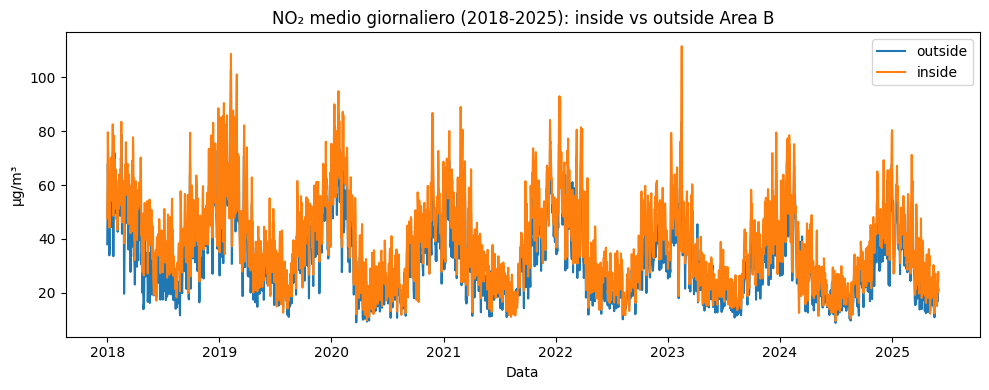

In [ ]:
# 1️⃣ Calcolo del flag inside_areaB (se non l'hai già fatto)
gdf2m_clean["inside_areaB"] = gdf2m_clean.geometry.within(polyB)

# 2️⃣ Estrai la data dal timestamp di inizio
gdf2m_clean["date"] = pd.to_datetime(gdf2m_clean["Start"]).dt.date

# 3️⃣ Calcola la media NO₂ giornaliera per inside/outside
daily = (
    gdf2m_clean
    .groupby(["date","inside_areaB"])["Value"]
    .mean()
    .reset_index()
)

# 4️⃣ Pivot per confronto diretto
pivot = daily.pivot(index="date", columns="inside_areaB", values="Value")
pivot.columns = ["outside","inside"]

# 5️⃣ Anteprima tabellare
print(pivot.head())

# 6️⃣ Grafico comparativo
fig, ax = plt.subplots(figsize=(10,4))
pivot.plot(ax=ax)
ax.set_title("NO₂ medio giornaliero (2018-2025): inside vs outside Area B")
ax.set_xlabel("Data")
ax.set_ylabel("µg/m³")
plt.tight_layout()
plt.show()

In [ ]:
# 1️⃣ Filter the DataFrame to get rows where inside_areaB is True
inside_areaB_df = gdf2m_clean[gdf2m_clean['inside_areaB'] == True]

# 2️⃣ Get the unique values from the 'Samplingpoint' column of the filtered DataFrame
unique_sampling_points_inside_areaB = inside_areaB_df['Samplingpoint'].unique()

# 3️⃣ Print the unique sampling points inside Area B
print("Unique Sampling Points inside Area B:", unique_sampling_points_inside_areaB)

Unique Sampling Points inside Area B: ['SPO.IT0477A_8_chemi_1973-11-01_00:00:00'
 'SPO.IT0705A_8_chemi_1989-11-01_00:00:00'
 'SPO.IT0761A_8_chemi_1991-10-01_00:00:00'
 'SPO.IT1016A_8_chemi_1995-05-01_00:00:00'
 'SPO.IT1692A_8_chemi_2007-06-23_00:00:00']


In [ ]:
# 1️⃣ Filter the DataFrame to get rows where inside_areaB is True
outside_areaB_df = gdf2m_clean[gdf2m_clean['inside_areaB'] == False]

# 2️⃣ Get the unique values from the 'Samplingpoint' column of the filtered DataFrame
unique_sampling_points_outside_areaB = outside_areaB_df['Samplingpoint'].unique()

# 3️⃣ Print the unique sampling points inside Area B
print("Unique Sampling Points inside Area B:", unique_sampling_points_outside_areaB)

Unique Sampling Points inside Area B: ['SPO.IT0480A_8_chemi_1974-11-01_00:00:00'
 'SPO.IT0592A_8_chemi_1982-11-01_00:00:00'
 'SPO.IT0694A_8_chemi_1988-11-01_00:00:00'
 'SPO.IT0706A_8_chemi_1989-11-01_00:00:00'
 'SPO.IT1034A_8_chemi_1995-11-01_00:00:00'
 'SPO.IT1290A_8_chemi_1994-02-02_00:00:00'
 'SPO.IT1459A_8_chemi_1999-02-01_00:00:00'
 'SPO.IT1650A_8_chemi_2003-12-09_00:00:00'
 'SPO.IT1743A_8_chemi_2005-10-20_00:00:00'
 'SPO.IT2098A_8_chemi_2013-02-08_00:00:00'
 'SPO.IT2232A_8_chemi_2007-02-23_00:00:00']


In [ ]:
gdf2m_clean.to_csv("/content/drive/MyDrive/data_science_lab_on_smart_cities/geomilan_no2.csv", index=False)

NameError: name 'gdf2m_clean' is not defined

# ERA5 data

In [ ]:
### non eseguire se si hanno già i dati
### i dati di prova sono data_0.nc e data_0-2.nc

c = cdsapi.Client()

# variabili, area, giorni e orari che ti interessano
bbox = [45.6, 9.0, 45.3, 9.3]
variables = [
    "2m_temperature",
    "2m_dewpoint_temperature",
    "10m_u_component_of_wind",
    "10m_v_component_of_wind",
    "boundary_layer_height"
]
times = [f"{h:02d}:00" for h in range(24)]

# periodo complessivo
years = [2025]
months = [1, 2, 3, 4, 5]

for y in years:
  for m in months:
    month_str = f"{m:02d}"
    # calcola numero di giorni in quel mese
    ndays = calendar.monthrange(y, m)[1]
    days = [f"{d:02d}" for d in range(1, ndays+1)]
    target = f"/content/drive/MyDrive/data_science_lab_on_smart_cities/era5_{y}_{month_str}.zip"

    c.retrieve(
        "reanalysis-era5-land",
        {
            "product_type": "reanalysis",
            "format":       "zip",
            "variable":     variables,
            "year":         [str(y)],
            "month":        [month_str],
            "day":          days,
            "time":         times,
            "area":         bbox,
            "download_format":       "zip",
        "data_format": "netcdf"
        },
        target,
    )
    print("Scaricato:", target)


2025-06-04 09:38:18,349 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-06-04 09:38:18,794 INFO Request ID is 6901c428-480e-4f90-b6fb-62c737d574aa
INFO:ecmwf.datastores.legacy_client:Request ID is 6901c428-480e-4f90-b6fb-62c737d574aa
2025-06-04 09:38:18,981 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-06-04 09:44:40,037 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-06-04 09:52:43,372 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


ef2b309d75ca64fc1f326929eaaf15f5.zip:   0%|          | 0.00/206k [00:00<?, ?B/s]

Scaricato: /content/drive/MyDrive/data_science_lab_on_smart_cities/era5_2025_01.zip


2025-06-04 09:52:46,042 INFO Request ID is 68a590f4-3e79-48bf-bc1e-bee431368356
INFO:ecmwf.datastores.legacy_client:Request ID is 68a590f4-3e79-48bf-bc1e-bee431368356
2025-06-04 09:52:46,201 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-06-04 09:53:00,714 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-06-04 09:59:12,150 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


cf098d4ea16ff0e83fc68b1b9a17eafb.zip:   0%|          | 0.00/192k [00:00<?, ?B/s]

Scaricato: /content/drive/MyDrive/data_science_lab_on_smart_cities/era5_2025_02.zip


2025-06-04 09:59:14,568 INFO Request ID is 716314fa-8777-4b95-a196-284aeb375389
INFO:ecmwf.datastores.legacy_client:Request ID is 716314fa-8777-4b95-a196-284aeb375389
2025-06-04 09:59:14,727 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-06-04 09:59:36,467 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-06-04 10:07:40,919 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


1906e475effb597423f4a3650658711.zip:   0%|          | 0.00/206k [00:00<?, ?B/s]

Scaricato: /content/drive/MyDrive/data_science_lab_on_smart_cities/era5_2025_03.zip


2025-06-04 10:07:43,293 INFO Request ID is 86b4b5e1-88c0-4b0c-8831-38ee4488b99a
INFO:ecmwf.datastores.legacy_client:Request ID is 86b4b5e1-88c0-4b0c-8831-38ee4488b99a
2025-06-04 10:07:43,779 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-06-04 10:07:52,701 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-06-04 10:16:06,313 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


ad78f5158a6c7c26985fe89e0b3d1c5.zip:   0%|          | 0.00/201k [00:00<?, ?B/s]

Scaricato: /content/drive/MyDrive/data_science_lab_on_smart_cities/era5_2025_04.zip


2025-06-04 10:16:08,700 INFO Request ID is 9bc4d747-5c67-4e8e-b1ad-0b333d78525b
INFO:ecmwf.datastores.legacy_client:Request ID is 9bc4d747-5c67-4e8e-b1ad-0b333d78525b
2025-06-04 10:16:08,869 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-06-04 10:17:00,881 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-06-04 10:24:31,349 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


48063741eef5da2eddc1308a2e6d1f5f.zip:   0%|          | 0.00/199k [00:00<?, ?B/s]

Scaricato: /content/drive/MyDrive/data_science_lab_on_smart_cities/era5_2025_05.zip


In [ ]:
### non eseguire se si hanno già i dati
### i dati di prova sono data_0.nc e data_0-2.nc

# Cartelle di input/output
zip_files = glob.glob("/content/drive/MyDrive/data_science_lab_on_smart_cities/era5/era5_20*.zip")  # es. era5_2019_01.zip e era5_2019_02.zip
output_dir = "/content/ERA5_extract"

os.makedirs(output_dir, exist_ok=True)

for zf in zip_files:
    with zipfile.ZipFile(zf, "r") as archive:
        # crea una sotto-cartella con lo stesso nome del zip (senza .zip)
        month_folder = os.path.join(output_dir, os.path.basename(zf).replace(".zip",""))
        os.makedirs(month_folder, exist_ok=True)
        archive.extractall(path=month_folder)
        print(f"Estratto {zf} in {month_folder}")


Estratto /content/drive/MyDrive/data_science_lab_on_smart_cities/era5/era5_2018_01.zip in /content/ERA5_extract/era5_2018_01
Estratto /content/drive/MyDrive/data_science_lab_on_smart_cities/era5/era5_2018_02.zip in /content/ERA5_extract/era5_2018_02
Estratto /content/drive/MyDrive/data_science_lab_on_smart_cities/era5/era5_2018_03.zip in /content/ERA5_extract/era5_2018_03
Estratto /content/drive/MyDrive/data_science_lab_on_smart_cities/era5/era5_2018_04.zip in /content/ERA5_extract/era5_2018_04
Estratto /content/drive/MyDrive/data_science_lab_on_smart_cities/era5/era5_2018_05.zip in /content/ERA5_extract/era5_2018_05
Estratto /content/drive/MyDrive/data_science_lab_on_smart_cities/era5/era5_2018_06.zip in /content/ERA5_extract/era5_2018_06
Estratto /content/drive/MyDrive/data_science_lab_on_smart_cities/era5/era5_2018_07.zip in /content/ERA5_extract/era5_2018_07
Estratto /content/drive/MyDrive/data_science_lab_on_smart_cities/era5/era5_2018_08.zip in /content/ERA5_extract/era5_2018_08


In [ ]:
gdf2m_clean = pd.read_csv("/content/drive/MyDrive/data_science_lab_on_smart_cities/geomilan_no2.csv")

In [ ]:
# 1) Trova tutti i file NetCDF nelle sottocartelle di 'ERA5_extract'
base_dir = "/content/ERA5_extract"
nc_files = []
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".nc"):
            nc_files.append(os.path.join(root, file))

# 2) Apri ciascun NetCDF e seleziona le variabili di interesse
datasets = []
for fpath in nc_files:
    ds_month = xr.open_dataset(fpath)
    # Rinomina se esiste 'valid_time' in 'time'
    if "valid_time" in ds_month.coords:
        ds_month = ds_month.rename({"valid_time": "time"})
    # Scegli le variabili presenti tra queste
    var_list = []
    for v in ["u10", "v10", "t2m", "d2m", "boundary_layer_height"]:
        if v in ds_month.data_vars:
            var_list.append(v)
    ds_sel = ds_month[var_list]
    datasets.append(ds_sel)

# 3) Concatena lungo la dimensione "time"
ds = xr.concat(datasets, dim="time", data_vars="minimal", coords="minimal", compat="override")

# 4) Calcola wind_speed e umidità relativa (RH)
if "t2m" in ds and "d2m" in ds:
    ds["T2m_C"]  = ds["t2m"] - 273.15
    ds["Td2m_C"] = ds["d2m"] - 273.15

if "u10" in ds and "v10" in ds:
    ds["wind_speed"] = np.sqrt(ds["u10"]**2 + ds["v10"]**2)

if "T2m_C" in ds and "Td2m_C" in ds:
    alpha = (17.27 * ds["Td2m_C"]) / (237.7 + ds["Td2m_C"])
    beta  = (17.27 * ds["T2m_C"])  / (237.7 + ds["T2m_C"])
    ds["RH"] = 100 * (np.exp(alpha) / np.exp(beta))

# 5) Rimuovi variabili intermedie non più necessarie
to_drop = [v for v in ["t2m", "d2m", "u10", "v10", "T2m_C", "Td2m_C"] if v in ds]
if to_drop:
    ds = ds.drop_vars(to_drop)

# 6) Coordinate stazioni da gdf2m_clean
coords_correct = (
    gdf2m_clean[['Samplingpoint', 'lat', 'lon']]
    .drop_duplicates(subset=["Samplingpoint"])
    .reset_index(drop=True)
)

# 7) Crea DataArray di lat/lon per interpolazione
lats = xr.DataArray(
    coords_correct["lat"].values,
    dims="station",
    coords={"station": coords_correct["Samplingpoint"].values}
)
lons = xr.DataArray(
    coords_correct["lon"].values,
    dims="station",
    coords={"station": coords_correct["Samplingpoint"].values}
)

# 8) Interpola dataset alle posizioni delle stazioni
ds_pts = ds.interp(
    latitude  = lats,
    longitude = lons,
    method    = "nearest"
)

# 9) Verifica variabili finali
print("Variabili disponibili in ds_pts:", list(ds_pts.data_vars))

Variabili disponibili in ds_pts: ['wind_speed', 'RH']


In [ ]:
# 10) Converti ciascuna variabile in DataFrame separatamente
#    – Boundary layer height, se c’è
has_blh = "boundary_layer_height" in ds_pts.data_vars
if has_blh:
    df_blh = ds_pts["boundary_layer_height"].to_dataframe().reset_index()[["time", "station", "boundary_layer_height"]]
    df_blh = df_blh.rename(columns={"boundary_layer_height": "blh"})

#    – Wind speed
df_ws = ds_pts["wind_speed"].to_dataframe().reset_index()[["time", "station", "wind_speed"]]

#    – Relative Humidity
df_rh = ds_pts["RH"].to_dataframe().reset_index()[["time", "station", "RH"]]

# 11) Unisci i DataFrame a seconda di blh
if has_blh:
    df_meteo = df_blh.merge(df_ws, on=["time", "station"]).merge(df_rh, on=["time", "station"])
else:
    df_meteo = df_ws.merge(df_rh, on=["time", "station"])

# 12) Rinomina le colonne e mantieni solo quelle necessarie
df_meteo = df_meteo.rename(columns={
    "time":    "datetime",
    "station": "Samplingpoint"
})

keep_cols = ["datetime", "Samplingpoint", "wind_speed", "RH"]
if has_blh:
    keep_cols.insert(2, "blh")

df_meteo = df_meteo[keep_cols].copy()

# 13) Converti datetime in pandas.Timestamp
df_meteo["datetime"] = pd.to_datetime(df_meteo["datetime"])

# Anteprima finale
print(df_meteo.head())


    datetime                            Samplingpoint  wind_speed         RH
0 2023-04-01  SPO.IT0477A_8_chemi_1973-11-01_00:00:00    1.795377  95.442352
1 2023-04-01  SPO.IT0480A_8_chemi_1974-11-01_00:00:00    1.795377  95.442352
2 2023-04-01  SPO.IT0592A_8_chemi_1982-11-01_00:00:00    1.652282  96.875671
3 2023-04-01  SPO.IT0694A_8_chemi_1988-11-01_00:00:00    1.867630  93.232056
4 2023-04-01  SPO.IT0705A_8_chemi_1989-11-01_00:00:00    1.795377  95.442352


In [ ]:
import os
import xarray as xr
import numpy as np
import pandas as pd

# 1) Trova tutti i file NetCDF nelle sottocartelle di 'ERA5_extract'
base_dir = "/content/ERA5_extract"
nc_files = []
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".nc"):
            nc_files.append(os.path.join(root, file))

# 2) Apri ciascun NetCDF e seleziona le variabili di interesse
datasets = []
for fpath in nc_files:
    ds_month = xr.open_dataset(fpath)

    if "valid_time" in ds_month.coords:
        ds_month = ds_month.rename({"valid_time": "time"})

    var_list = [v for v in ["u10", "v10", "t2m", "d2m", "boundary_layer_height"] if v in ds_month.data_vars]
    ds_sel = ds_month[var_list]
    datasets.append(ds_sel)

# 3) Concatena lungo la dimensione "time"
ds = xr.concat(datasets, dim="time", data_vars="minimal", coords="minimal", compat="override")

# 4) Coordinate delle stazioni
coords_correct = (
    gdf2m_clean[['Samplingpoint', 'lat', 'lon']]
    .drop_duplicates(subset=["Samplingpoint"])
    .reset_index(drop=True)
)

lats = xr.DataArray(
    coords_correct["lat"].values,
    dims="station",
    coords={"station": coords_correct["Samplingpoint"].values}
)
lons = xr.DataArray(
    coords_correct["lon"].values,
    dims="station",
    coords={"station": coords_correct["Samplingpoint"].values}
)

# 5) Interpola il dataset alle posizioni delle stazioni
ds_pts = ds.interp(
    latitude  = lats,
    longitude = lons,
    method    = "nearest"
)

# 6) Calcola wind_speed e umidità relativa (RH) **dopo** l'interpolazione
if "u10" in ds_pts and "v10" in ds_pts:
    ds_pts["wind_speed"] = np.sqrt(ds_pts["u10"]**2 + ds_pts["v10"]**2)

if "t2m" in ds_pts and "d2m" in ds_pts:
    T2m_C  = ds_pts["t2m"] - 273.15
    Td2m_C = ds_pts["d2m"] - 273.15

    # Filtro per evitare problemi numerici (es. -inf, overflow)
    T2m_C = T2m_C.where(T2m_C > -80)
    Td2m_C = Td2m_C.where(Td2m_C > -80)

    alpha = (17.27 * Td2m_C) / (237.7 + Td2m_C)
    beta  = (17.27 * T2m_C) / (237.7 + T2m_C)

    ds_pts["RH"] = 100 * (np.exp(alpha) / np.exp(beta))

# 7) Converte ciascuna variabile in DataFrame
dfs = []

if "boundary_layer_height" in ds_pts.data_vars:
    df_blh = ds_pts["boundary_layer_height"].to_dataframe().reset_index()[["time", "station", "boundary_layer_height"]]
    df_blh = df_blh.rename(columns={"boundary_layer_height": "blh"})
    dfs.append(df_blh)

if "wind_speed" in ds_pts.data_vars:
    df_ws = ds_pts["wind_speed"].to_dataframe().reset_index()[["time", "station", "wind_speed"]]
    dfs.append(df_ws)

if "RH" in ds_pts.data_vars:
    df_rh = ds_pts["RH"].to_dataframe().reset_index()[["time", "station", "RH"]]
    dfs.append(df_rh)

# 8) Unisci tutti i DataFrame
from functools import reduce
df_meteo = reduce(lambda left, right: pd.merge(left, right, on=["time", "station"], how="outer"), dfs)

# 9) Rinomina e seleziona colonne
df_meteo = df_meteo.rename(columns={
    "time": "datetime",
    "station": "Samplingpoint"
})

# Mantieni solo le colonne principali
keep_cols = ["datetime", "Samplingpoint"] + [col for col in ["blh", "wind_speed", "RH"] if col in df_meteo.columns]
df_meteo = df_meteo[keep_cols].copy()

# 10) Conversione sicura del datetime
df_meteo["datetime"] = pd.to_datetime(df_meteo["datetime"])

# 11) Output finale
print(df_meteo.info())
print(df_meteo.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1039280 entries, 0 to 1039279
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   datetime       1039280 non-null  datetime64[ns]
 1   Samplingpoint  1039280 non-null  object        
 2   wind_speed     714505 non-null   float32       
 3   RH             714505 non-null   float32       
dtypes: datetime64[ns](1), float32(2), object(1)
memory usage: 23.8+ MB
None
    datetime                            Samplingpoint  wind_speed         RH
0 2018-01-01  SPO.IT0477A_8_chemi_1973-11-01_00:00:00    0.821264  85.715370
1 2018-01-01  SPO.IT0480A_8_chemi_1974-11-01_00:00:00    0.821264  85.715370
2 2018-01-01  SPO.IT0592A_8_chemi_1982-11-01_00:00:00    0.934646  88.971237
3 2018-01-01  SPO.IT0694A_8_chemi_1988-11-01_00:00:00    1.170871  89.017067
4 2018-01-01  SPO.IT0705A_8_chemi_1989-11-01_00:00:00    0.821264  85.715370


In [ ]:
df_meteo.shape

(1039280, 4)

In [ ]:
print("Intervallo:", df_meteo["datetime"].min(), "→", df_meteo["datetime"].max())

Intervallo: 2018-01-01 00:00:00 → 2025-05-30 10:00:00


In [ ]:
df_meteo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1039280 entries, 0 to 1039279
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   datetime       1039280 non-null  datetime64[ns]
 1   Samplingpoint  1039280 non-null  object        
 2   wind_speed     714505 non-null   float32       
 3   RH             714505 non-null   float32       
dtypes: datetime64[ns](1), float32(2), object(1)
memory usage: 23.8+ MB


In [ ]:
df_meteo.isna().sum()

,0
datetime,0
Samplingpoint,0
wind_speed,324775
RH,324775


In [ ]:
print("u10 NaN:", ds_pts["u10"].isnull().sum().item())
print("v10 NaN:", ds_pts["v10"].isnull().sum().item())
print("t2m NaN:", ds_pts["t2m"].isnull().sum().item())
print("d2m NaN:", ds_pts["d2m"].isnull().sum().item())

u10 NaN: 324775
v10 NaN: 324775
t2m NaN: 324775
d2m NaN: 324775


In [ ]:
df_meteo.groupby("Samplingpoint")[["wind_speed", "RH"]].apply(lambda x: x.isna().all()).sum()

,0
wind_speed,5
RH,5


In [ ]:
nan_counts = df_meteo.groupby("Samplingpoint")[["wind_speed", "RH"]].apply(lambda x: x.isna().all())
print(nan_counts[nan_counts["wind_speed"] | nan_counts["RH"]])


                                         wind_speed    RH
Samplingpoint                                            
SPO.IT0706A_8_chemi_1989-11-01_00:00:00        True  True
SPO.IT1034A_8_chemi_1995-11-01_00:00:00        True  True
SPO.IT1459A_8_chemi_1999-02-01_00:00:00        True  True
SPO.IT1650A_8_chemi_2003-12-09_00:00:00        True  True
SPO.IT2098A_8_chemi_2013-02-08_00:00:00        True  True


In [ ]:
print(coords_correct.head())
print("Min lat/lon in NetCDF:", float(ds.latitude.min()), float(ds.longitude.min()))
print("Max lat/lon in NetCDF:", float(ds.latitude.max()), float(ds.longitude.max()))


                             Samplingpoint       lat      lon
0  SPO.IT0477A_8_chemi_1973-11-01_00:00:00  45.49556  9.19139
1  SPO.IT0480A_8_chemi_1974-11-01_00:00:00  45.53389  9.23639
2  SPO.IT0592A_8_chemi_1982-11-01_00:00:00  45.52250  9.04472
3  SPO.IT0694A_8_chemi_1988-11-01_00:00:00  45.55139  9.22806
4  SPO.IT0705A_8_chemi_1989-11-01_00:00:00  45.46278  9.19583
Min lat/lon in NetCDF: 45.3 9.0
Max lat/lon in NetCDF: 45.6 9.3


In [ ]:
print(gdf2m_clean[gdf2m_clean['Samplingpoint'] == 'SPO.IT2098A_8_chemi_2013-02-08_00:00:00'])

                                  Samplingpoint  Pollutant  \
698890  SPO.IT2098A_8_chemi_2013-02-08_00:00:00          8   
698891  SPO.IT2098A_8_chemi_2013-02-08_00:00:00          8   
698892  SPO.IT2098A_8_chemi_2013-02-08_00:00:00          8   
698893  SPO.IT2098A_8_chemi_2013-02-08_00:00:00          8   
698894  SPO.IT2098A_8_chemi_2013-02-08_00:00:00          8   
...                                         ...        ...   
974103  SPO.IT2098A_8_chemi_2013-02-08_00:00:00          8   
974104  SPO.IT2098A_8_chemi_2013-02-08_00:00:00          8   
974105  SPO.IT2098A_8_chemi_2013-02-08_00:00:00          8   
974106  SPO.IT2098A_8_chemi_2013-02-08_00:00:00          8   
974107  SPO.IT2098A_8_chemi_2013-02-08_00:00:00          8   

                      Start                  End      Value    Unit AggType  \
698890  2018-01-01 00:00:00  2018-01-01 01:00:00  57.549978  ug.m-3    hour   
698891  2018-01-01 01:00:00  2018-01-01 02:00:00  49.756240  ug.m-3    hour   
698892  2018-01-01

In [ ]:
df_meteo.to_csv("/content/drive/MyDrive/data_science_lab_on_smart_cities/milan_WRH.csv", index=False)

# Merge

In [ ]:
# 1) Trasforma 'Start' in pandas.Timestamp
gdf2m_clean['datetime'] = pd.to_datetime(gdf2m_clean['Start'])

# 2) Mantieni solo le colonne necessarie da gdf2m_clean
#    (puoi includere anche 'lon','lat' o altri campi, se ti servono dopo)
df_no2 = gdf2m_clean[['datetime', 'Samplingpoint', 'Value', 'inside_areaB']].copy()

#df_no2['datetime']=df_no2['datetime'].dt.floor('H').equals(df_no2['datetime'])
#df_meteo['datetime']=df_meteo['datetime'].dt.floor('H').equals(df_meteo['datetime'])

# 3) Assicurati che df_meteo abbia le colonne 'datetime','Samplingpoint','wind_speed','RH'
#    (derivato dai NetCDF di ERA5 in precedenza)

# 4) Unisci i due DataFrame su ['datetime', 'Samplingpoint']
df_merged = pd.merge(
    df_no2,
    df_meteo,
    on=['datetime', 'Samplingpoint'],
    how='inner'
)

# 5) Facoltativo: elimina eventuali righe con missing su Value, wind_speed o RH
df_merged = df_merged.dropna(subset=['Value', 'wind_speed', 'RH']).copy()

# Ora df_merged ha almeno queste colonne:
#   - datetime       (pandas.Timestamp)
#   - Samplingpoint  (ID stazione)
#   - Value          (concentrazione NO₂)
#   - inside_areaB   (True/False)
#   - wind_speed     (covariata meteo)
#   - RH             (covariata meteo)

print(df_merged.head())


/tmp/ipython-input-39-1457278208.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_no2['datetime']=df_no2['datetime'].dt.floor('H').equals(df_no2['datetime'])
/tmp/ipython-input-39-1457278208.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_meteo['datetime']=df_meteo['datetime'].dt.floor('H').equals(df_meteo['datetime'])


In [ ]:
df_merged.shape

(678184, 6)

In [ ]:
df_merged.isna().sum()

,0
datetime,0
Samplingpoint,0
Value,0
inside_areaB,0
wind_speed,0
RH,0


In [ ]:
print("Intervallo:", df_merged["datetime"].min(), "→", df_merged["datetime"].max())

Intervallo: 2018-01-01 00:00:00 → 2025-05-30 10:00:00


# Plot

In [ ]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 27.3 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/geopandas/plotting.py:306: UserWarning: You passed a edgecolor/edgecolors ('whie') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  collection = ax.scatter(x, y, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)


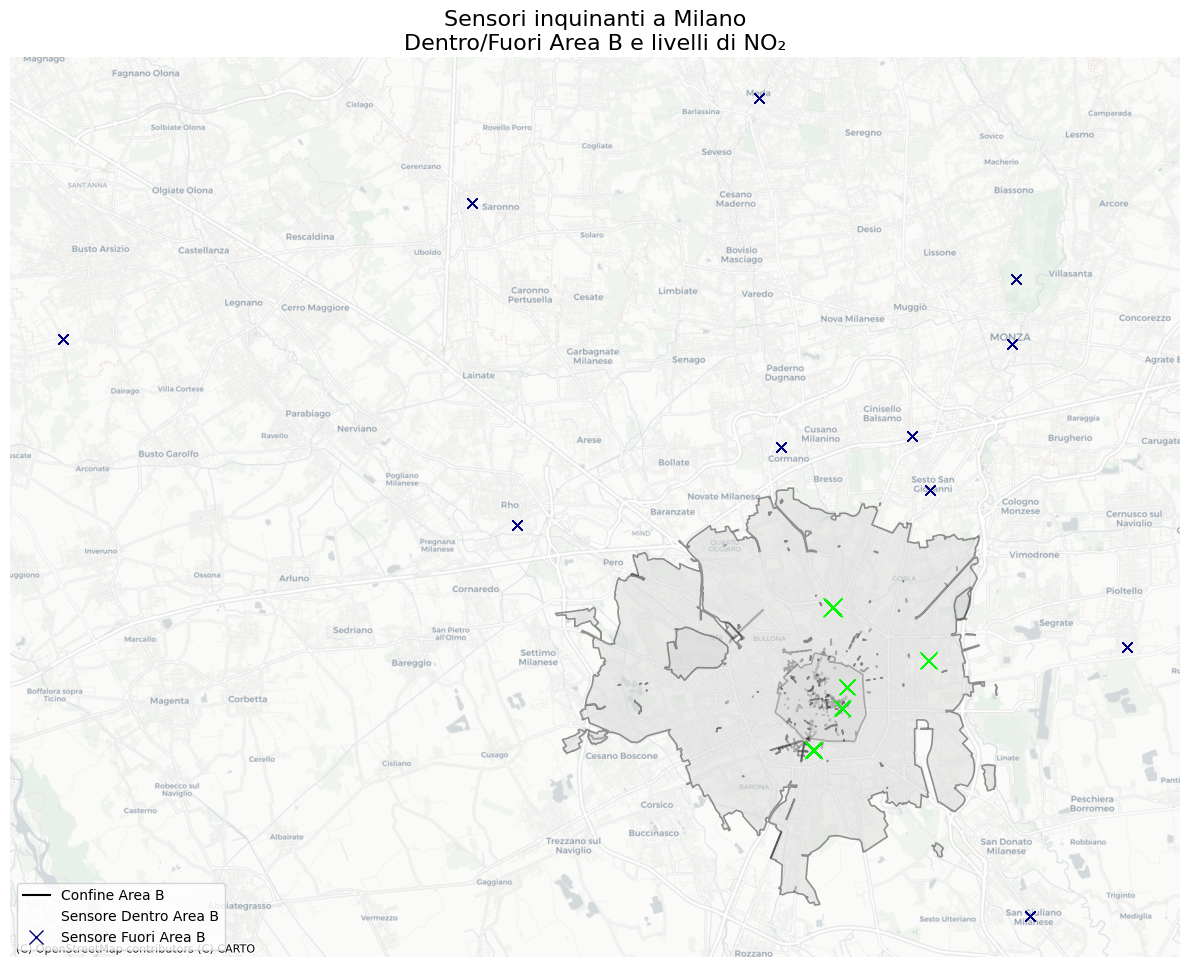

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# 1) Riproietto in Web Mercator
gdf_areaB_3857   = gdf_areaB.to_crs(epsg=3857)
gdf2m_clean_3857 = gdf2m_clean.to_crs(epsg=3857)

# (Opzionale) Creo una dimensione proporzionale alla concentrazione NO2
min_no2 = gdf2m_clean_3857['Value'].min()
max_no2 = gdf2m_clean_3857['Value'].max()
gdf2m_clean_3857['size_NO2'] = ((gdf2m_clean_3857['Value'] - min_no2) /
                                 (max_no2 - min_no2)) * 180 + 20

# 2) Inizializzo la figura e l’asse
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_title('Sensori inquinanti a Milano\nDentro/Fuori Area B e livelli di NO₂', fontsize=16)
ax.set_axis_off()  # toglie gli assi, dato che siamo su Web Mercator

# 3) Plotto l’Area B
gdf_areaB_3857.plot(
    ax=ax,
    facecolor='lightgray',
    edgecolor='black',
    alpha=0.4,
    linewidth=1.2,
    label='Area B'
)

# 4) Plotto la rete stradale (se l’avessi)
# gdf_strade_milano_3857.plot(
#     ax=ax,
#     color='none',
#     edgecolor='gray',
#     linewidth=0.5,
#     alpha=0.5,
#     zorder=2,
#     label='Strade'
# )

# 5) Plot dei punti “dentro” Area B
inside = gdf2m_clean_3857[gdf2m_clean_3857['inside_areaB'] == True]
outside = gdf2m_clean_3857[gdf2m_clean_3857['inside_areaB'] == False]

inside.plot(
    ax=ax,
    marker='x',
    color='lime',
    markersize=inside['size_NO2'],
    edgecolor='whie',
    linewidth=0.7,
    alpha=0.8,
    legend=False,    # metteremo una colorbar a parte
    zorder=4
)

outside.plot(
    ax=ax,
    marker='x',
    color='navy',
    markersize=50,
    linewidth=0.7,
    alpha=0.7,
    label='Fuori Area B',
    zorder=4
)

# 6) Aggiungo la basemap (zoom opportuno)
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,  # oppure OpenStreetMap.Mapnik
    zoom=12
)

# 8) Legenda manuale (per il marker “fuori Area B” e “confine Area B”)
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], linestyle='-', color='black', lw=1.5, label='Confine Area B'),
    Line2D([0], [0], linestyle='none', marker='o', markerfacecolor='none',
           markeredgecolor='white', markersize=10, label='Sensore Dentro Area B'),
    Line2D([0], [0], linestyle='none', marker='x', color='navy', markersize=10,
           label='Sensore Fuori Area B')
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=10)

plt.tight_layout()
plt.show()
